In [28]:
# Core libraries
import pandas as pd
import polars as pl
from datetime import datetime

# Internal data access
from op_analytics.coreutils.duckdb_inmem.client import init_client, register_parquet_relation
# from op_analytics.coreutils.clickhouse.oplabs import run_query_oplabs

# configurations
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import config
from helper import fetch_eip1559_params
from core import compute_next_base_fee, validate_next_base_fee

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.style.use("seaborn-v0_8-whitegrid")  # clean background
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "sans-serif",
    "font.sans-serif": ["Inter", "DejaVu Sans"],
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# config
CHAIN = config.CHAIN
BLOCK_DATE = config.BLOCK_DATE

In [11]:
# pull the eip1559 params on BLOCK_DATE
eip1559_params_output = fetch_eip1559_params(CHAIN, BLOCK_DATE)
eip1559_params_output

⚠️ Invalid EIP-1559 params (elasticity=0, denominator=0) for unichain on 2025-08-16, trying GitHub fallback...
✅ Fetched fallback params for unichain from GitHub


,eip1559_elasticity,eip1559_denominator,gas_limit,latest_block_number,latest_block_timestamp,basefee_scalar,operator_fee_constant,operator_fee_scalar
0,6,50,30000000,None,None,None,None,None


In [4]:
# get the blocks data
parquet_paths = [
    f"gs://oplabs-tools-data-sink/ingestion/blocks_v1/chain={CHAIN}/dt={BLOCK_DATE}/*.parquet"
]

# Load into DuckDB
ctx = init_client()
block_view = register_parquet_relation("block_view", parquet_paths)

2025-11-18 22:14:34 [info     ] initialized duckdb at /var/folders/80/jqw6kmgj7j34j0x4mcs6hcl00000gn/T/8shos59f/op-analytics.duck.db filename=client.py lineno=118 process=69901
2025-11-18 22:14:34 [info     ] create duckddb gcs secret      filename=client.py lineno=66 process=69901
2025-11-18 22:14:46 [info     ] registered view: 'block_view' using 1 parquet paths filename=client.py lineno=319 process=69901


In [29]:
# Get samples 
df_sample = ctx.client.sql(f"SELECT * FROM {block_view} ORDER BY number LIMIT 10000").pl()

# convert unix timestamp to datetime

df_sample = df_sample.with_columns(
    pl.col("timestamp").map_elements(lambda x: datetime.fromtimestamp(x)).alias("datetime")
)
print(df_sample.head())

df_sample.schema

shape: (5, 25)
┌─────────┬──────────┬────────────┬──────────┬───┬────────────┬──────────┬────────────┬────────────┐
│ network ┆ chain_id ┆ timestamp  ┆ number   ┆ … ┆ transactio ┆ chain    ┆ dt         ┆ datetime   │
│ ---     ┆ ---      ┆ ---        ┆ ---      ┆   ┆ n_count    ┆ ---      ┆ ---        ┆ ---        │
│ str     ┆ i32      ┆ u32        ┆ i64      ┆   ┆ ---        ┆ str      ┆ date       ┆ datetime[μ │
│         ┆          ┆            ┆          ┆   ┆ i64        ┆          ┆            ┆ s]         │
╞═════════╪══════════╪════════════╪══════════╪═══╪════════════╪══════════╪════════════╪════════════╡
│ mainnet ┆ 130      ┆ 1755302400 ┆ 24554041 ┆ … ┆ 9          ┆ unichain ┆ 2025-08-16 ┆ 2025-08-16 │
│         ┆          ┆            ┆          ┆   ┆            ┆          ┆            ┆ 08:00:00   │
│ mainnet ┆ 130      ┆ 1755302401 ┆ 24554042 ┆ … ┆ 21         ┆ unichain ┆ 2025-08-16 ┆ 2025-08-16 │
│         ┆          ┆            ┆          ┆   ┆            ┆          ┆  

/var/folders/80/jqw6kmgj7j34j0x4mcs6hcl00000gn/T/ipykernel_69901/3729048975.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_sample = df_sample.with_columns(


Schema([('network', String),
        ('chain_id', Int32),
        ('timestamp', UInt32),
        ('number', Int64),
        ('hash', String),
        ('parent_hash', String),
        ('nonce', String),
        ('sha3_uncles', String),
        ('logs_bloom', String),
        ('transactions_root', String),
        ('state_root', String),
        ('receipts_root', String),
        ('withdrawals_root', String),
        ('miner', String),
        ('difficulty', Float64),
        ('total_difficulty', Float64),
        ('size', Int64),
        ('base_fee_per_gas', Int64),
        ('gas_used', Int64),
        ('gas_limit', Int64),
        ('extra_data', String),
        ('transaction_count', Int64),
        ('chain', String),
        ('dt', Date),
        ('datetime', Datetime(time_unit='us', time_zone=None))])

In [32]:
# simulate the next base fee
df_simulate = compute_next_base_fee(
    df_sample,
    eip1559_elasticity=eip1559_params_output["eip1559_elasticity"],
    eip1559_denominator=eip1559_params_output["eip1559_denominator"],
)

# compare the predicted next base fee with the actual next base fee
df_output, summary = validate_next_base_fee(df_simulate)
summary

{'rows_compared': 9999, 'mismatches': 8707}

In [33]:
# inspect predicted vs actual next base fee
df_output["diff"].value_counts().sort(by="diff")

diff,count
i64,u32
null,1
-12,2
-10,2
-9,1
-8,10
…,…
2,677
3,960
4,1634


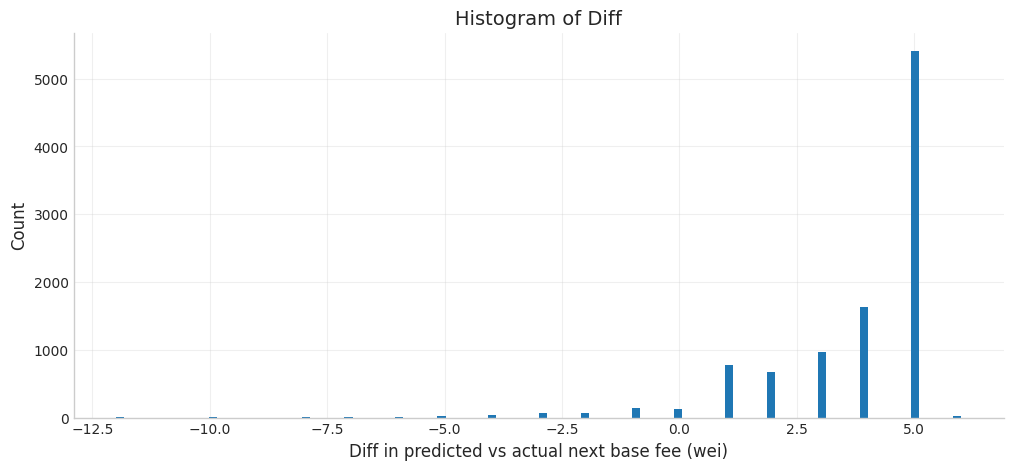

In [36]:
# plot the histogram of diff
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df_output["diff"], bins=100)
ax.set_title("Histogram of Diff")
ax.set_xlabel("Diff in predicted vs actual next base fee (wei)")
ax.set_ylabel("Count")
plt.show()

In [25]:
# find out where diff is the max
row_max_diff = df_output.filter(pl.col("diff") == df_output["diff"].max())
row_max_diff

network,chain_id,timestamp,number,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,withdrawals_root,miner,difficulty,total_difficulty,size,base_fee_per_gas,gas_used,gas_limit,extra_data,transaction_count,chain,dt,target_gas,base_fee_delta,predicted_next_base_fee_per_gas,actual_next_base_fee_per_gas,next_block_number,is_consecutive,diff
str,i32,u32,i64,str,str,str,str,str,str,str,str,str,str,f64,f64,i64,i64,i64,i64,str,i64,str,date,i64,i64,i64,i64,i64,bool,i64
"""mainnet""",130,1755302696,24554337,"""0x2a17627b75edeaceadb1d8a928a1…","""0xddf9e24f7d828417bf681af86ea2…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x0000000000000000000000000000…","""0xd718b226041803233c43c1122bd4…","""0x2d24690c76d7c52d94b71e8eb020…","""0x3e0b068cda0defa8d33e3b9914df…","""0x80c8e594759b2a758d248ea301ab…","""0x4200000000000000000000000000…",0.0,0.0,1030,325,76412,30000000,"""0x00000000fa00000006""",2,"""unichain""",2025-08-16,5000000,-7,318,324,24554338,true,6
"""mainnet""",130,1755302962,24554603,"""0xb423623e6e992e956621a062335a…","""0x3db57657fda31043301dc3242e35…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x0000000000000000000000000000…","""0x130d00ca892c8b11e4719a998b1b…","""0x3f22657090b28a7db188f692d487…","""0x16b6ef64dd540fd9a606a61b8300…","""0x80c8e594759b2a758d248ea301ab…","""0x4200000000000000000000000000…",0.0,0.0,1030,323,76424,30000000,"""0x00000000fa00000006""",2,"""unichain""",2025-08-16,5000000,-7,316,322,24554604,true,6
"""mainnet""",130,1755303252,24554893,"""0x0ff3c3643d9ba5ac68f608b01780…","""0xad7c61f79458fefb83d47a178481…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x0000000000000000000000000000…","""0x976fb877e64bcf08528dce2ef1cb…","""0x9739f744476f170f3d1a55a7d514…","""0x8711333196a797f6bf9911669c3c…","""0x80c8e594759b2a758d248ea301ab…","""0x4200000000000000000000000000…",0.0,0.0,1030,320,76424,30000000,"""0x00000000fa00000006""",2,"""unichain""",2025-08-16,5000000,-7,313,319,24554894,true,6
"""mainnet""",130,1755303887,24555528,"""0xa23a2ba02a5b3bf044b8e5c1c944…","""0xa84aabd11ed9f1488b9baf442c26…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x0000000000000000000000000000…","""0x6809d6afa805da3e4c08347c9afc…","""0x5f74b08ac66d97b118eb2a25df2c…","""0x213a1ef1ef321c46c922b73a43c6…","""0x80c8e594759b2a758d248ea301ab…","""0x4200000000000000000000000000…",0.0,0.0,1030,317,76424,30000000,"""0x00000000fa00000006""",2,"""unichain""",2025-08-16,5000000,-7,310,316,24555529,true,6
"""mainnet""",130,1755304123,24555764,"""0xebef7226446634ba5d4f3342b5f1…","""0x1d5ec1c77d9174bef73a06cc093e…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x0000000000000000000000000000…","""0xad4c1681a8daaec07f5ba0f79f6a…","""0x71c893171061fae1980318b783bc…","""0xcdea43f42f517e06ffd8121638f3…","""0x80c8e594759b2a758d248ea301ab…","""0x4200000000000000000000000000…",0.0,0.0,1030,337,76400,30000000,"""0x00000000fa00000006""",2,"""unichain""",2025-08-16,5000000,-7,330,336,24555765,true,6
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""mainnet""",130,1755311048,24562689,"""0xadcada5fd42bd3803134bf7be153…","""0xf6deb853e4ed2fceb8639572a2a8…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x0000000000000000000000000000…","""0x1eddfb75d06c8408dfd7596c23eb…","""0x04e6eeec2c16e73bfff554aa7a79…","""0x4149b509c8fa174f2244a0f60afb…","""0x872a039123869e1d6396c0fa7daf…","""0x4200000000000000000000000000…",0.0,0.0,1030,349,76424,30000000,"""0x00000000fa00000006""",2,"""unichain""",2025-08-16,5000000,-7,342,348,24562690,true,6
"""mainnet""",130,1755311392,24563033,"""0x1928b62d2f12eadd6665ac67d47c…","""0xe6a89d1b4abd0831816b90bec32d…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x0000000000000000000000000000…","""0x5a074fe7204fd09be4117698ed0a…","""0xdf82594299ae296d9b697ddbd600…","""0x90de9354afc821e77aff12e6c03c…","""0x07834a8f5b997b7ea6b0ae3f22d3…","""0x420000000000000000000000

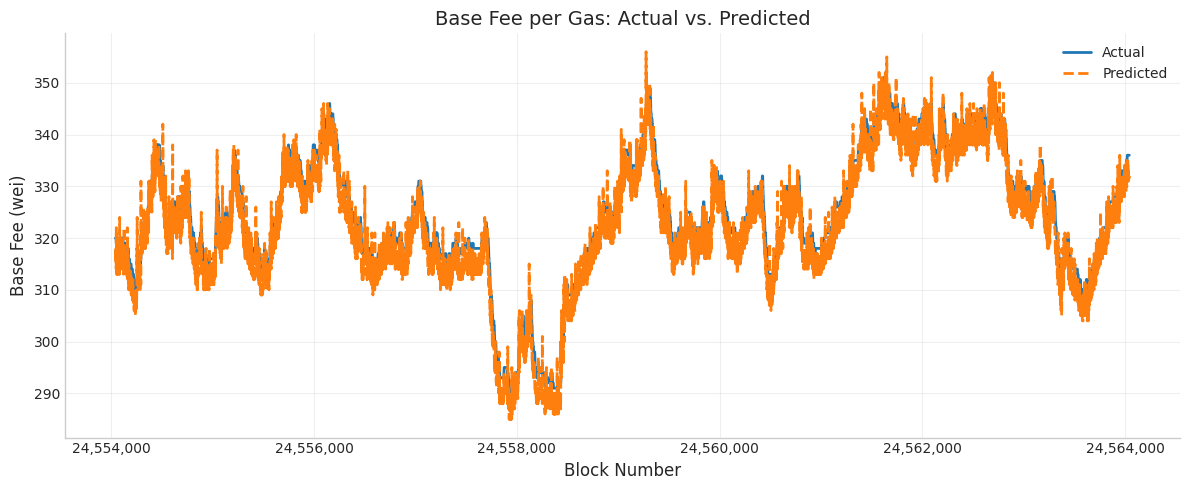

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_output["number"], df_output["base_fee_per_gas"], label="Actual", linewidth=2)
ax.plot(df_output["number"], df_output["predicted_next_base_fee_per_gas"], label="Predicted", linestyle="--", linewidth=2)
ax.set_title("Base Fee per Gas: Actual vs. Predicted")
ax.set_xlabel("Block Number")
ax.set_ylabel("Base Fee (wei)")
ax.legend(frameon=False)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()